__Final Project : President Trump Tweets and Stock Market Performance__

__Group Members:__

__Name 1:__ Gizem Baranoglu Dammati - 11924000

__Name 2:__ Brigitta Földi - 11849064

__Name 3:__ Tara Shirehpazazari - 61803573


# Import Packages

__Events__

Donald Trump Won Election on: 09-11-2016

Donald Trump Presidency Started on: 20-01-2017 17:00


In [1]:
#Import the necessary packages

import pandas as pd
import numpy as np
import re
import string
import json
from collections import Counter
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.random.seed(42)
np.set_printoptions(precision=2)

# Tweets Data

## Import Data

We use the readily available <b>"Twitter Tweets for Donald J. Trump (@realdonaldtrump)"</b> dataset from Harvard Dataverse with around 40K tweets from 2009 to 2019.

<b>Source</b>: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FKJEBIL

In [2]:
#Import tweets raw data from ndjson file into a dataframe to inspect the data fields
tweets_raw = pd.read_json('realdonaldtrump.ndjson',lines=True)
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40241 entries, 0 to 40240
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   contributors               0 non-null      float64            
 1   coordinates                2415 non-null   object             
 2   created_at                 40241 non-null  datetime64[ns, UTC]
 3   entities                   40241 non-null  object             
 4   favorite_count             40241 non-null  int64              
 5   favorited                  40241 non-null  bool               
 6   geo                        2415 non-null   object             
 7   id                         40241 non-null  int64              
 8   id_str                     40241 non-null  int64              
 9   in_reply_to_screen_name    2873 non-null   object             
 10  in_reply_to_status_id      2393 non-null   float64            
 11  in

In [3]:
#Display the top rows of the dataframe
tweets_raw.head()

,contributors,coordinates,created_at,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,...,possibly_sensitive,extended_entities,quoted_status,quoted_status_id,quoted_status_id_str,retweeted_status,withheld_copyright,withheld_in_countries,withheld_scope,scopes
0,nan,None,2009-05-04 18:54:25+00:00,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",850,False,None,1698308935,1698308935,None,...,nan,NaN,NaN,nan,nan,NaN,nan,NaN,NaN,NaN
1,nan,None,2009-05-05 01:00:10+00:00,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",282,False,None,1701461182,1701461182,None,...,nan,NaN,NaN,nan,nan,NaN,nan,NaN,NaN,NaN
2,nan,None,2009-05-08 13:38:08+00:00,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",16,False,None,1737479987,1737479987,None,...,nan,NaN,NaN,nan,nan,NaN,nan,NaN,NaN,NaN
3,nan,None,2009-05-08 20:40:15+00:00,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",28,False,None,1741160716,1741160716,None,...,nan,NaN,NaN,nan,nan,NaN,nan,NaN,NaN,NaN
4,nan,None,2009-05-12 14:07:28+00:00,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",1950,False,None,1773561338,1773561338,None,...,nan,NaN,NaN,nan,nan,NaN,nan,NaN,NaN,NaN


In [4]:
#Display a sample row of data
tweets_raw.iloc[0]

contributors                                                               NaN
coordinates                                                               None
created_at                                           2009-05-04 18:54:25+00:00
entities                     {'hashtags': [], 'symbols': [], 'urls': [], 'u...
favorite_count                                                             850
favorited                                                                False
geo                                                                       None
id                                                                  1698308935
id_str                                                              1698308935
in_reply_to_screen_name                                                   None
in_reply_to_status_id                                                      NaN
in_reply_to_status_id_str                                                  NaN
in_reply_to_user_id                                 

In [5]:
#Display a sample tweet text of one row
tweets_raw.iloc[0]['text']

'Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!'

## Data Exploration & Stats

We explore the raw dataset to understand the data better and add necessary fields to help extract the tweets we are interested in for our analysis.

In [6]:
#Check the total no. of tweets and the time range of the tweets in the dataframe
display("Number of tweets: "+str(len(tweets_raw)))
display("Tweets range from: "+str(tweets_raw.created_at.min()) + " to " + str(tweets_raw.created_at.max()))

'Number of tweets: 40241'

'Tweets range from: 2009-05-04 18:54:25+00:00 to 2019-07-11 15:52:19+00:00'

In [7]:
#Save the Election and Presidency Dates
election_win = '2016-11-09'
presidency_start = '2017-01-20'

In [8]:
#Add a flag to each tweet whether the tweet was made as a president/after winning the election
tweets_raw['is_president'] = tweets_raw['created_at'].apply(lambda x: 1 if x > pd.to_datetime(presidency_start,utc=1) else 0)
tweets_raw['is_win'] = tweets_raw['created_at'].apply(lambda x: 1 if x > pd.to_datetime(election_win,utc=1) else 0)
tweets_raw[['created_at','is_win','is_president']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40241 entries, 0 to 40240
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   created_at    40241 non-null  datetime64[ns, UTC]
 1   is_win        40241 non-null  int64              
 2   is_president  40241 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2)
memory usage: 943.3 KB


In [9]:
#Filtering tweets made as President and saving them to a new dataframe
tweets_president = tweets_raw[tweets_raw['is_president'] == 1]
tweets_president.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8537 entries, 31704 to 40240
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   contributors               0 non-null      float64            
 1   coordinates                0 non-null      object             
 2   created_at                 8537 non-null   datetime64[ns, UTC]
 3   entities                   8537 non-null   object             
 4   favorite_count             8537 non-null   int64              
 5   favorited                  8537 non-null   bool               
 6   geo                        0 non-null      object             
 7   id                         8537 non-null   int64              
 8   id_str                     8537 non-null   int64              
 9   in_reply_to_screen_name    314 non-null    object             
 10  in_reply_to_status_id      309 non-null    float64            
 11 

In [10]:
#Checking the minimum date of this new dataframe to confirm the tweet date is after the start of Presidency
tweets_president.created_at.min()

Timestamp('2017-01-20 00:40:51+0000', tz='UTC')

In [11]:
#Display the total no. of tweets made as President
display("Total tweets made as President: " +str(tweets_president.id_str.nunique()))

'Total tweets made as President: 8537'

In [12]:
#Create a new dataframe with only required columns from the President tweets dataframe
df = tweets_president[['id','id_str','created_at','text']]
df.reset_index(inplace=True,drop=True)
df.head()

,id,id_str,created_at,text
0,822242449053614081,822242449053614080,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...
1,822298747421986828,822298747421986816,2017-01-20 04:24:33+00:00,Thank you for a wonderful evening in Washingto...
2,822421390125043713,822421390125043712,2017-01-20 12:31:53+00:00,It all begins today! I will see you at 11:00 A...
3,822501803615014918,822501803615014912,2017-01-20 17:51:25+00:00,Today we are not merely transferring power fro...
4,822501939267141634,822501939267141632,2017-01-20 17:51:58+00:00,"power from Washington, D.C. and giving it back..."


In [13]:
#Check a row text sample
df['text'][0]

'Thank you for joining us at the Lincoln Memorial tonight- a very special evening! Together, we are going to MAKE AM… https://t.co/OSxa3BamHs'

## Feature Extraction

We primariliy work on the simple tweets dataframe from above.

1. We clean the tweet text data by removing punctuation and stopwords while preserving thes original tweet text column.
2. We then extract the feature based on the clean text and stop words.
3. We also identify the Parts of Speech and generate features based on the Parts of Speech tagging.

### Cleaning - Punctuation & Stopwords

In [14]:
def text_cleaner(raw_text):
    """Function takes raw text data and removes punctuation and stop words and 
    converts the text to lower case and returns the clean text and the stop words in the raw text"""
    
    #word tokenize to create word tokens of the raw text
    tokens = nltk.word_tokenize(raw_text)
    
    #Create an NLTK Text object from the word tokens
    text = nltk.Text(tokens)
    
    #Remove punctuation from the text object and store in a new variable
    text_clean = [w for w in text if w not in string.punctuation]
    
    #store the stopwords in the raw text to a new variable
    text_stop = [w.lower() for w in text_clean if w.lower() in stopwords.words('english')]
    
    #Remove the stopwords and convert the above clean text to lower case
    text_clean = [w.lower() for w in text_clean if w.lower() not in stopwords.words('english')]
    
    #Return the clean text data and stop words in the raw text data
    return text_clean, text_stop

In [15]:
#add two new columns of clean lower case text after removing stop words/punctuation and only stop words
df['text_clean'], df['text_stop'] = zip(*df['text'].map(text_cleaner))
df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,id_str,created_at,text,text_clean,text_stop
0,822242449053614081,822242449053614080,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...,"[thank, joining, us, lincoln, memorial, tonigh...","[you, for, at, the, a, very, we, are, to]"
1,822298747421986828,822298747421986816,2017-01-20 04:24:33+00:00,Thank you for a wonderful evening in Washingto...,"[thank, wonderful, evening, washington, d.c., ...","[you, for, a, in]"
2,822421390125043713,822421390125043712,2017-01-20 12:31:53+00:00,It all begins today! I will see you at 11:00 A...,"[begins, today, see, 11:00, a.m., swearing-in,...","[it, all, i, will, you, at, for, the, the, the]"
3,822501803615014918,822501803615014912,2017-01-20 17:51:25+00:00,Today we are not merely transferring power fro...,"[today, merely, transferring, power, one, admi...","[we, are, not, from, to, or, from, to, but, we..."
4,822501939267141634,822501939267141632,2017-01-20 17:51:58+00:00,"power from Washington, D.C. and giving it back...","[power, washington, d.c., giving, back, americ...","[from, and, it, to, you, the]"


In [16]:
#Extract the features based on the original tweet text, clean text and stop words in the tweet

#Original tweet text length
df['text_len'] = df['text'].apply(lambda x: len(x))

#no. of words in the original tweet text
df['text_nwords'] = df['text'].apply(lambda x: len(word_tokenize(x)))

#no. of words in the clean text
df['text_clean_nwords'] = df['text_clean'].apply(lambda x: len(x))

#no. of stopwords in the original tweet text
df['text_stop_nwords'] = df['text_stop'].apply(lambda x: len(x))

#Display the top rows of the dataframe
df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,id,id_str,created_at,text,text_clean,text_stop,text_len,text_nwords,text_clean_nwords,text_stop_nwords
0,822242449053614081,822242449053614080,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...,"[thank, joining, us, lincoln, memorial, tonigh...","[you, for, at, the, a, very, we, are, to]",140,26,14,9
1,822298747421986828,822298747421986816,2017-01-20 04:24:33+00:00,Thank you for a wonderful evening in Washingto...,"[thank, wonderful, evening, washington, d.c., ...","[you, for, a, in]",91,15,8,4
2,822421390125043713,822421390125043712,2017-01-20 12:31:53+00:00,It all begins today! I will see you at 11:00 A...,"[begins, today, see, 11:00, a.m., swearing-in,...","[it, all, i, will, you, at, for, the, the, the]",112,24,10,10
3,822501803615014918,822501803615014912,2017-01-20 17:51:25+00:00,Today we are not merely transferring power fro...,"[today, merely, transferring, power, one, admi...","[we, are, not, from, to, or, from, to, but, we...",136,25,13,11
4,822501939267141634,822501939267141632,2017-01-20 17:51:58+00:00,"power from Washington, D.C. and giving it back...","[power, washington, d.c., giving, back, americ...","[from, and, it, to, you, the]",92,18,8,6


### Parts of Speech

In [17]:
def pos_classifier(pos):
    """Function to classify/map NLTK Parts of Speech symbol to respective Parts of Speech Category Name"""
    if pos.startswith("N"):
        return "Noun"
    elif pos.startswith("J"):
        return "Adjective"
    elif pos.startswith("RB"):
        return "Adverb"
    elif pos.startswith("V"):
        return "Verb"
    else:
        return "Other"

In [18]:
def pos_counter(text_clean):
    """Function to count the number of nouns, verbs, adverbs, adjectives in the input text"""
    
    #Tag Parts of Speech of the clean text
    text_clean_pos = nltk.pos_tag(text_clean)

    #Count the no. of words for each POS tag
    counts = Counter(tag for word,tag in text_clean_pos)
    
    #Saving the POS tag and count as a dictionary
    pos_dict = dict((word, float(count)) for word,count in counts.items())

    #Saving the dictionary to a DataFrame
    df_pos = pd.DataFrame(pos_dict.items(),columns=['POS','Share'])

    #Classifying based on the POS Symbol and above defined pos_classifier function
    df_pos['Main POS'] = df_pos['POS'].apply(pos_classifier)
    df_pos.sort_values(by=['Share'],inplace=True,ascending=False,ignore_index=True)

    #Printing the resulting DF and grouped based on new classication
    df_pos_agg = df_pos.groupby('Main POS').sum().sort_values(by=['Share'],ascending=False)
    
    dicty = df_pos_agg['Share'].to_dict()
    
    #return the no. of Nouns, Verbs, Adverbs and Ajectives in the clean text
    return dicty.get('Noun'), dicty.get('Verb'), dicty.get('Adverb'), dicty.get('Adjective')

In [19]:
#Add columns for no. of of nouns, verbs, adverbs, adjectives in the cleaned tweet
df['pos_noun'], df['pos_verb'], df['pos_adverb'], df['pos_adj'] = zip(*df['text_clean'].map(pos_counter))
df['Date'] = df['created_at'].dt.date.astype('datetime64')

#Display the first and last row if the dataframe
df.iloc[[0, -1]]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,id_str,created_at,text,text_clean,text_stop,text_len,text_nwords,text_clean_nwords,text_stop_nwords,pos_noun,pos_verb,pos_adverb,pos_adj,Date
0,822242449053614081,822242449053614080,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...,"[thank, joining, us, lincoln, memorial, tonigh...","[you, for, at, the, a, very, we, are, to]",140,26,14,9,5.000,3.000,1.000,4.000,2017-01-20
8536,1149345683138367491,1149345683138367488,2019-07-11 15:52:19+00:00,...or a very nervous and skinny version of Poc...,"[..., nervous, skinny, version, pocahontas, 1/...","[or, a, very, and, of, as, your, than, what, y...",140,29,11,12,6.000,None,1.000,2.000,2019-07-11


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8537 entries, 0 to 8536
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id                 8537 non-null   int64              
 1   id_str             8537 non-null   int64              
 2   created_at         8537 non-null   datetime64[ns, UTC]
 3   text               8537 non-null   object             
 4   text_clean         8537 non-null   object             
 5   text_stop          8537 non-null   object             
 6   text_len           8537 non-null   int64              
 7   text_nwords        8537 non-null   int64              
 8   text_clean_nwords  8537 non-null   int64              
 9   text_stop_nwords   8537 non-null   int64              
 10  pos_noun           8534 non-null   object             
 11  pos_verb           7483 non-null   object             
 12  pos_adverb         3524 non-null   object       

# Stock Market Data

For the stock market performance data we have used the S&P500 daily dataset from 2016 to 2020.

In [21]:
#Read the S&P500 stock data from csv to DataFrame
df_stockmarket = pd.read_csv('Stock Market Data S&P500_2016_2020.csv', sep=";", parse_dates=['Date'],index_col=False)

#Sort the data by date from old to new and reset the index
df_stockmarket.sort_values(by='Date',ascending=True,inplace=True)
df_stockmarket.reset_index(inplace=True,drop=True)

#Display the data
df_stockmarket.head()

,Date,Open,High,Low,Close
0,2016-01-01,10633.250,10691.890,10610.800,10680.480
1,2016-01-04,10672.750,10679.720,10474.770,10491.530
2,2016-01-05,10526.510,10545.920,10464.690,10506.400
3,2016-01-06,10522.920,10539.770,10431.750,10451.930
4,2016-01-07,10389.340,10389.340,10183.960,10195.660


In [22]:
#Add two more columns to the stock data:
    #Daily Difference: the difference between opening and closing prices of a certain day
    #Closing Prices Diff: difference between today and previous day closing prices

df_stockmarket['Daily Difference'] = df_stockmarket.apply(lambda x: x['Close']- x['Open'], axis=1)
df_stockmarket['Closing Prices Diff'] = df_stockmarket['Close'].diff()
df_stockmarket.head()

,Date,Open,High,Low,Close,Daily Difference,Closing Prices Diff
0,2016-01-01,10633.250,10691.890,10610.800,10680.480,47.230,nan
1,2016-01-04,10672.750,10679.720,10474.770,10491.530,-181.220,-188.950
2,2016-01-05,10526.510,10545.920,10464.690,10506.400,-20.110,14.870
3,2016-01-06,10522.920,10539.770,10431.750,10451.930,-70.990,-54.470
4,2016-01-07,10389.340,10389.340,10183.960,10195.660,-193.680,-256.270


In [23]:
df_stockmarket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 986 non-null    datetime64[ns]
 1   Open                 986 non-null    float64       
 2   High                 986 non-null    float64       
 3   Low                  986 non-null    float64       
 4   Close                986 non-null    float64       
 5   Daily Difference     986 non-null    float64       
 6   Closing Prices Diff  985 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 54.0 KB


# Merging Tweets and Stock Market Data

We merge the tweets data and the daily stock market performance data based on the <b>Date</b>. Since the stock market data is daily frequency and also is not available on certain days (non-working etc), the merged data would have missing values for the days where tweets were made and no stock market data is available. We will address this issue in the Preprocessing step later.

In [24]:
#Merge the tweets dataframe and the stock market dataframe on the Date column and store in a new dataframe
df_final = df.merge(df_stockmarket[['Date', 'Daily Difference', 'Closing Prices Diff']], on = 'Date', how = 'left')
df_final.head()

,id,id_str,created_at,text,text_clean,text_stop,text_len,text_nwords,text_clean_nwords,text_stop_nwords,pos_noun,pos_verb,pos_adverb,pos_adj,Date,Daily Difference,Closing Prices Diff
0,822242449053614081,822242449053614080,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...,"[thank, joining, us, lincoln, memorial, tonigh...","[you, for, at, the, a, very, we, are, to]",140,26,14,9,5.000,3.000,1.000,4.000,2017-01-20,-112.050,-107.780
1,822298747421986828,822298747421986816,2017-01-20 04:24:33+00:00,Thank you for a wonderful evening in Washingto...,"[thank, wonderful, evening, washington, d.c., ...","[you, for, a, in]",91,15,8,4,6.000,1.000,None,1.000,2017-01-20,-112.050,-107.780
2,822421390125043713,822421390125043712,2017-01-20 12:31:53+00:00,It all begins today! I will see you at 11:00 A...,"[begins, today, see, 11:00, a.m., swearing-in,...","[it, all, i, will, you, at, for, the, the, the]",112,24,10,10,5.000,2.000,1.000,1.000,2017-01-20,-112.050,-107.780
3,822501803615014918,822501803615014912,2017-01-20 17:51:25+00:00,Today we are not merely transferring power fro...,"[today, merely, transferring, power, one, admi...","[we, are, not, from, to, or, from, to, but, we...",136,25,13,11,6.000,1.000,1.000,None,2017-01-20,-112.050,-107.780
4,822501939267141634,822501939267141632,2017-01-20 17:51:58+00:00,"power from Washington, D.C. and giving it back...","[power, washington, d.c., giving, back, americ...","[from, and, it, to, you, the]",92,18,8,6,4.000,2.000,None,2.000,2017-01-20,-112.050,-107.780


In [25]:
#Check the data for null-values in stock performance data
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8537 entries, 0 to 8536
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   8537 non-null   int64              
 1   id_str               8537 non-null   int64              
 2   created_at           8537 non-null   datetime64[ns, UTC]
 3   text                 8537 non-null   object             
 4   text_clean           8537 non-null   object             
 5   text_stop            8537 non-null   object             
 6   text_len             8537 non-null   int64              
 7   text_nwords          8537 non-null   int64              
 8   text_clean_nwords    8537 non-null   int64              
 9   text_stop_nwords     8537 non-null   int64              
 10  pos_noun             8534 non-null   object             
 11  pos_verb             7483 non-null   object             
 12  pos_adverb          

# Preprocessing Data

In [26]:
#Fill Null values in the dataframe (e.g. stock market performace) with 0
df_final.fillna(0,inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8537 entries, 0 to 8536
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   8537 non-null   int64              
 1   id_str               8537 non-null   int64              
 2   created_at           8537 non-null   datetime64[ns, UTC]
 3   text                 8537 non-null   object             
 4   text_clean           8537 non-null   object             
 5   text_stop            8537 non-null   object             
 6   text_len             8537 non-null   int64              
 7   text_nwords          8537 non-null   int64              
 8   text_clean_nwords    8537 non-null   int64              
 9   text_stop_nwords     8537 non-null   int64              
 10  pos_noun             8537 non-null   float64            
 11  pos_verb             8537 non-null   float64            
 12  pos_adverb          

In [27]:
#Define X and Y vector features and output
X_data = df_final[['text_len', 'text_nwords', 'text_clean_nwords', 
            'text_stop_nwords', 'pos_noun', 'pos_verb', 'pos_adverb', 'pos_adj']].to_numpy()
Y_data = df_final[['Daily Difference', 'Closing Prices Diff']].to_numpy()
Y_daily = np.sign(Y_data[:, 0])
Y_closing = np.sign(Y_data[:, 1])

display("Size of the Features: "+str(np.shape(X_data)))
display("Size of the Output: "+str(np.shape(Y_data)))

'Size of the Features: (8537, 8)'

'Size of the Output: (8537, 2)'

In [28]:
#Split test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_daily, test_size=0.2, random_state=1, stratify=Y_daily)

display("Size of the Train Features: "+str(np.shape(X_train)))
display("Size of the Train Output: "+str(np.shape(Y_train)))

'Size of the Train Features: (6829, 8)'

'Size of the Train Output: (6829,)'

In [29]:
#Apply StandardScaler to transform the train and test data
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [30]:
def visualize(param, err_train, err_test, x_label, labels):
    """Function to visualize the error rate of the model on both train and test data"""
    (fig, ax) = plt.subplots(1, 2, figsize = (16,6))
    ax[0].plot(param, err_train, '.-')
    ax[0].grid()
    ax[0].set_title('Training')
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel('Training error')
    ax[0].legend(labels)
    ax[1].plot(param, err_test, '.-')
    ax[1].grid()
    ax[1].set_title('Testing')
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel('Testing error')
    ax[1].legend(labels)

# Model 1: Perceptron

In [31]:
#Set the range of parameters to run the model on
eta = np.linspace(0.001, 1.0, 50)

#Variables to store the train and test error for each parameter value
err_test = np.zeros((len(eta), 1))
err_train = np.zeros((len(eta), 1))

for idx, h0 in enumerate(eta):
    #Initiate a Perception with respective parameter values
    ppn = Perceptron(max_iter = 1000, eta0=h0, random_state=1)
    #Fit the model with the train data
    ppn.fit(X_train, Y_train)

    # Predict train and test data
    Y_pred = ppn.predict(X_test)
    Y_train_pred = ppn.predict(X_train)
    #print("Total error: {} out of {}.".format((Y_pred != Y_test).sum(), len(Y_pred)))

    #Compute error rate for train and test data output
    err_train[idx] = sum(Y_train!=Y_train_pred)/len(Y_train)
    err_test[idx] = sum(Y_test!=Y_pred)/len(Y_test)

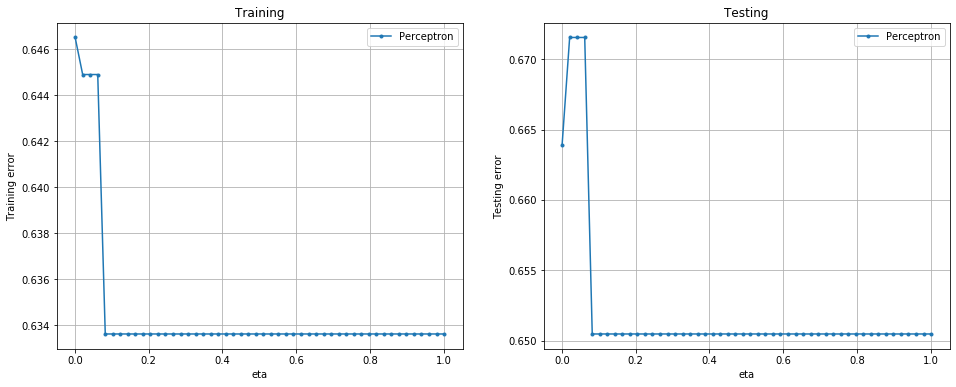

In [32]:
#Visualize the train and test error of the model for various value of parameter: eta
visualize(eta, err_train, err_test, 'eta', ['Perceptron'])

We notice that the training and testing error are a bit high initially for eta < 0.1 and later reduce and stabilize at 0.63 and 0.65 for train and test data respectively.

# Model 2: Decision Tree

In [33]:
#Set the range of parameters to run the model on
max_depth = np.linspace(1,10,10)

#Variables to store the train and test error for each parameter value
err_test = np.zeros((len(max_depth), 1))
err_train = np.zeros((len(max_depth), 1))

for idx, md in enumerate(max_depth):
    #Initiate a DecisionTreeClassifier with respective parameter values
    dct = DecisionTreeClassifier(max_depth = md, random_state = 1)
    dct.fit(X_train, Y_train)

    # Predict train and test data
    Y_pred = dct.predict(X_test)
    Y_train_pred = dct.predict(X_train)
    #print("Total error: {} out of {}.".format((Y_pred != Y_test).sum(), len(Y_pred)))

    #Compute error rate for train and test data output
    err_train[idx] = sum(Y_train!=Y_train_pred)/len(Y_train)
    err_test[idx] = sum(Y_test!=Y_pred)/len(Y_test)

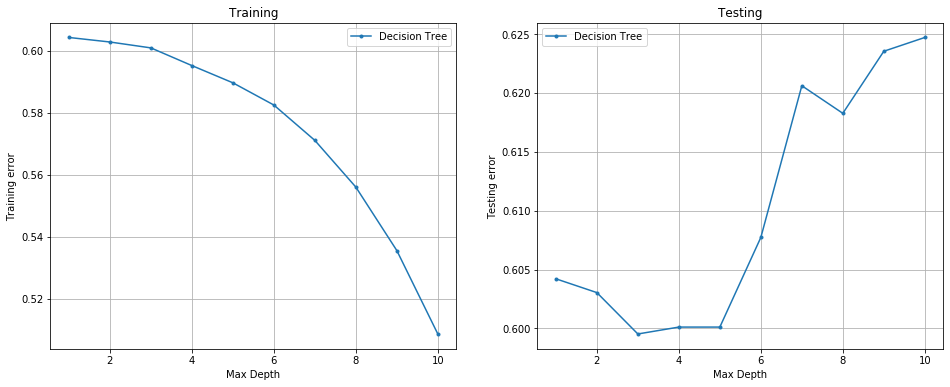

In [34]:
#Visualize the train and test error of the model for various value of parameter: max_depth
visualize(max_depth, err_train, err_test, 'Max Depth', ['Decision Tree'])

We notice that as the max_depth increases, the training error keeps reducing while the testing error stays stable until max_depth = 5 and then starts to increase - which could imply we are overfitting the data after a max_depth = 5.

# Effect of Test size on Both Models

In [35]:
#Set the range of parameters to run the model on
train_test_ratio = np.arange(0.05, 1.0, 0.05)

#Variables to store the train and test error for each parameter value
err_train = np.zeros((len(train_test_ratio), 2))
err_test = np.zeros((len(train_test_ratio), 2))

for idx, rat in enumerate(train_test_ratio):
    
    #Split test and train data
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_daily, test_size=rat, random_state=1, stratify=Y_daily)
        
    #Apply StandardScaler to transform the train and test data
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    
    
    # Initiate and Run the PERCEPTRON model
    ppn = Perceptron(max_iter = 100, eta0=0.25, random_state=1)
    ppn.fit(X_train, Y_train)

    # Predict train and test data
    Y_pred = ppn.predict(X_test)
    Y_train_pred = ppn.predict(X_train)
    #print("Total error: {} out of {}.".format((Y_pred != Y_test).sum(), len(Y_pred)))

    #Compute error rate for train and test data output
    err_train[idx, 0] = sum(Y_train!=Y_train_pred)/len(Y_train)
    err_test[idx, 0] = sum(Y_test!=Y_pred)/len(Y_test)
    
    
    # Initiate and Run the DECISION TREE model
    dct = DecisionTreeClassifier(max_depth = 4, random_state = 1)
    dct.fit(X_train, Y_train)

    # Predict train and test data
    Y_pred = dct.predict(X_test)
    Y_train_pred = dct.predict(X_train)
    #print("Total error: {} out of {}.".format((Y_pred != Y_test).sum(), len(Y_pred)))

    #Compute error rate for train and test data output
    err_train[idx, 1] = sum(Y_train!=Y_train_pred)/len(Y_train)
    err_test[idx, 1] = sum(Y_test!=Y_pred)/len(Y_test)

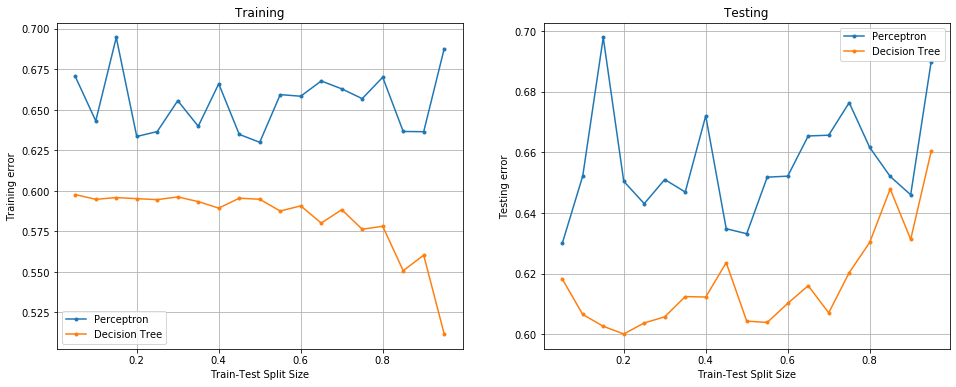

In [36]:
#Visualize the train and test error of the model for various value of parameter: Train-Test Split
visualize(train_test_ratio, err_train, err_test, 'Train-Test Split Size', ['Perceptron', 'Decision Tree'])

1. For Decision Tree model:
    We notice that as the test size increases, the training error keeps reducing while the testing error keeps dropping until test size = 0.2 and then starts to increase - which could imply we are overfitting the data.
    
2. For Percepton Model:
    The training error fluctuates evenly across the various test_sizes, while the test error reaches a minimum around test size = 0.5 for which the training error also is minimum.